# PA005: High Value Customer Identification ( Insiders )

## <font color ='red'> Ciclo 00 - Planejamento - Método IOT </font>

## <font color ='red'> Ciclo 01 - Métricas de Validação de clusters  </font>

## <font color ='red'> Ciclo 02 - Análise de Sillhoutte </font>

## <font color ='red'> Ciclo 03 - Statistical Descriptive </font>

# 0.0. Planejamento da solução (IOT)

## Input 

### Problema de Negócio 


1. Selecionar os clientes mais valiosos para integrar um programa de Fidelização chamado __"INSIDERS"__.
    
2. Conjunto de dados com as vendas de um e-commerce online, durante um periodo de um ano.( Nov 2015 to Dec 2017)

## Output

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista:
             cliente_id | is_insiders |
               10233    |    yes/1    |
               32456    |     no/0    | 
                
                
2. Relatório com as respostas das perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

    

## Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegíve? O qe são clientes de maior "valor" ?
    - Faturamento:
         - Alto Ticket médio
         - Alto LTV
         - Baixa Recência
         - Alta basket size
         - Baixa probabilidade de churn
         - Alta previsão de LTV
         - Alta propensão de compra
         
         
  - Custo:
      - Baixa taxa de devolução
      
      
- Experiência de compra:
     - Média alta das avaiações
    

2. Quantos clientes farão parte do grupo?
     - Número total de clientes
     - % do grupo Insiders
     
     
3. Quais as principais características desses clientes ?
    - Escverer caracteristicas do cliente:
         - Idade
         - Localização
         
    - Escrever caracteristicas do consumo 
         - Atributos da clusterização
    
    
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

   - Calcular o faturamento total da empresa durante o ano.
   - Calcular o faturamento (%) apenas do cluster Insiders.
   
   
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

    - Cálculo do LTV do grupo Insiders - > Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    - Análise de Cohort


6. Quais as condições para uma pessoa ser elegível ao Insiders ?

      - Definir a periodicidade(1 mês , 3 meses)
      - O "desempenho" do cliente está próximo da média do cluster Insiders
      - A pessoa precisa ser similar ou parecida com uma outra pessoa do grupo
    
    
7. Quais as condições para uma pessoa ser removida do Insiders ?

    - Definir a periodicidade(1 mês , 3 meses)
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.
    
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

    - Teste de Hipóteses
    - Teste A/B
    - Teste A/B Bayesiano

    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

   - Descontos
   - Preferências de compra
   - Produtos exclusivos
   - Visita a empresa
   - Sem frete

# 0.0 Imports

In [1]:
import re
import pandas                      as pd
import numpy                       as np
import seaborn                     as sns
import umap.umap_                  as umap

from IPython.core.display          import HTML
from matplotlib                    import pyplot            as plt


from pandas_profiling              import ProfileReport

from sklearn                       import cluster as c
from sklearn                       import metrics as m
from sklearn                       import decomposition as dd
from sklearn.cluster               import KMeans
from yellowbrick.cluster           import KElbowVisualizer , SilhouetteVisualizer
from plotly                        import express as px
from sklearn                       import preprocessing       as pp
from sklearn.manifold              import TSNE


import warnings

warnings.filterwarnings("ignore")

##  0.1 Helper Functions

In [2]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
    
my_settings()

##  0.2 Load Dataset


In [3]:
# load data
df_raw = pd.read_csv(r'../data/raw/Ecommerce.csv', encoding='cp1252')

# # drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'] , axis=1)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


# <font color ='red'> 1.0 Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 Data dimensios

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.4 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA


In [12]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]



In [13]:
# missing_invoice = df_missing['invoice_no'].drop_duplicates().to_list()
# missing_invoice[0:10]

# df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice) , :].head()

In [14]:
# create referance 

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000 , 19000+len(df_backup), 1)
df_backup.head()

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup , on='invoice_no' , how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns

df1 = df1.drop(columns=['customer_id_x' , 'customer_id_y' ] , axis = 1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.00
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.00


## 1.6 Changes dtypes


In [15]:
# invoice date

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'] , format='%d-%b-%y')

# customer_id

df1['customer_id'] = df1['customer_id'].astype('int64')

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64' , 'float64','datetime64[ns]'])


### 1.7.1 Numerical Attributs

In [18]:
# central tendency - mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std , min , max , range , skew , kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
mi = pd.DataFrame(num_attributes.apply(np.min)).T
ma = pd.DataFrame(num_attributes.apply(np.max)).T
ran = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([mi , ma ,ran, mean , median  , std,  skew ,  kurtosis]).T.reset_index()
m.columns = ['Attributes' , 'min' , 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtoses']
m

,Attributes,min,max,range,mean,median,std,skew,kurtoses
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72
2,customer_id,12346.00,22709.00,10363.00,16688.84,16249.00,2911.41,0.49,-0.80


### <font color=red>1.7.1.1 Numerical Attributs - Investigating</font>

1. Quantidade negativa( pode ser devolução ??)




2. Preço unitário igual a 0. (Pode ser promoção ?? )

### 1.7.2 Categorical Attributs

In [19]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No

In [20]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [21]:
# problema: Temos invoice com letras e numeros
# df1['invoice_no'].astype(int)


# identificação:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))) , :]
df_letter_invoices.head()

print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices['quantity'] < 0)))

Total number of invoices: 9291
Total number of negative quantity: 9291


#### Stock Code

In [22]:
# check stock code only characters
#df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))),'stock_code'].unique()

df1['stock_code'].loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+' , x)))].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

#### Description

In [23]:
df1.head()

# Ação: Delete Description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [24]:
len(df1['country'].unique())

38

In [25]:
df1['country'].value_counts(normalize=True)

United Kingdom         0.91
Germany                0.02
France                 0.02
EIRE                   0.02
Spain                  0.00
Netherlands            0.00
Belgium                0.00
Switzerland            0.00
Portugal               0.00
Australia              0.00
Norway                 0.00
Italy                  0.00
Channel Islands        0.00
Finland                0.00
Cyprus                 0.00
Sweden                 0.00
Unspecified            0.00
Austria                0.00
Denmark                0.00
Japan                  0.00
Poland                 0.00
Israel                 0.00
USA                    0.00
Hong Kong              0.00
Singapore              0.00
Iceland                0.00
Canada                 0.00
Greece                 0.00
Malta                  0.00
United Arab Emirates   0.00
European Community     0.00
RSA                    0.00
Lebanon                0.00
Lithuania              0.00
Brazil                 0.00
Czech Republic      

In [26]:
df1[['customer_id' , 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending= False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# <font color ='red'> 2.0 Filtragem de variaveis </font>

In [27]:
df2 = df1.copy()

In [28]:
# df1.loc[df1['unit_price'] > 0.04 , ['customer_id','description','unit_price'] ].sort_values('unit_price', ascending = True).head(10)

In [29]:
# ==== Numerical Attributes ====

# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04 , :]


# ==== Categorical Attributes ====
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'])]

# description
df2 = df2.drop('description', axis =1)

# map
df2 = df2[~df2['country'].isin (['European Community' , 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446]) ]


## quantity 
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]


# <font color ='red'> 3.0 Feature Engeneering </font>

In [30]:
df3 = df2.copy()

## 3.1 Feature Creation

In [31]:
# data reference

df_ref = df3.drop(['invoice_no','stock_code','quantity', 'invoice_date','unit_price','country'], axis = 1 ).drop_duplicates(ignore_index = True)


### 3.1.1. Gross Revenue

In [32]:
# Gross Revenue ( Faturamento = quantity * price)
df2_purchase.loc[: , 'gross_revenue'] = df2_purchase.loc[: , 'quantity'] * df2_purchase.loc[: , 'unit_price']

df_monetary = df2_purchase.loc[: , ['customer_id' , 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary,on='customer_id',how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [33]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[: ,[ 'customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref , df_recency , on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
dtype: int64

### 3.1.3. Quantity of purchased

In [34]:
# Numero de produtos
df_freq = (df2_purchase.loc[: ,['customer_id','invoice_no']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .count()
                                                            .reset_index()
                                                            .rename(columns={'invoice_no' : 'qtde_invoices'}))

df_ref = pd.merge(df_ref , df_freq , on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qtde_invoices    67
dtype: int64

### 3.1.4. Quantity total of items purchased


In [35]:
df_freq = df2_purchase.loc[: ,['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'qtde_items'})
df_ref = pd.merge(df_ref , df_freq , on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qtde_invoices    67
qtde_items       67
dtype: int64

### 3.1.5. Quantity of products purchased


In [36]:
df_freq = df2_purchase.loc[: ,['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns = {'stock_code' : 'qtde_products'})
df_ref = pd.merge(df_ref , df_freq , on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qtde_invoices    67
qtde_items       67
qtde_products    67
dtype: int64

### 3.1.6. Avg Ticket Value

In [37]:
# Avg ticket
df_avg_ticket = df2_purchase.loc[: ,['customer_id' , 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
#df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'] , 2)
df_ref = pd.merge(df_ref, df_avg_ticket,on='customer_id',how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qtde_invoices    67
qtde_items       67
qtde_products    67
avg_ticket       67
dtype: int64

### 3.1.7. Avg Recency Days

In [38]:
# Avarage recency days

df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=['False' , 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date


df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis =1)

df_aux = df_aux.drop(['invoice_date' , 'next_customer_id' , 'previous_date'], axis = 1).dropna()

# average rencecy
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref , df_avg_recency_days, on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qtde_invoices         67
qtde_items            67
qtde_products         67
avg_ticket            67
avg_recency_days    2794
dtype: int64

In [39]:
# df3.loc[df2['customer_id'] == 17850 , ['invoice_no', 'invoice_date']].drop_duplicates()

### 3.1.8. Frequency Purchase

In [40]:
df3_purchase = df2_purchase.copy()

In [41]:
# df3_max = df3[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max() # Ultima compra que o customer fez
# df3_min = df3[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min() # Primeira compra que o customer fez
# df3_purschase = df3[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count() 


# df3_purschase.head()

In [42]:
df_aux = df3_purchase[['invoice_no','customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_  = ('invoice_date', 'max'), 
                                                                                               min_  = ('invoice_date', 'min'), 
                                                                                               days_ = ('invoice_date', lambda x: (( x.max() - x.min() ).days)+ 1),
                                                                                               buy_  = ('invoice_date', 'count')).reset_index()

# Frequency 
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = pd.merge(df_ref , df_aux[['customer_id', 'frequency']], on='customer_id', how = 'left')

df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qtde_invoices         67
qtde_items            67
qtde_products         67
avg_ticket            67
avg_recency_days    2794
frequency             67
dtype: int64

### 3.1.9. Numbers of Returns

In [43]:
df_returns = df2_returns[['customer_id' , 'quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity' : 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1
df_ref = pd.merge(df_ref , df_returns, on ='customer_id' ,  how='left')

df_ref.loc[df_ref['qtde_returns'].isna() , 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qtde_invoices         67
qtde_items            67
qtde_products         67
avg_ticket            67
avg_recency_days    2794
frequency             67
qtde_returns           0
dtype: int64

### 3.2.0.  Basket Size - Quantidade de items por cesta ( Quantity)

In [44]:
df_aux = df3_purchase.loc[: , ['customer_id' , 'invoice_no', 'quantity']].groupby('customer_id').agg(n_purchase =('invoice_no' , 'nunique'),
                                                                                                     n_products=('quantity', 'sum')).reset_index()
# Calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref , df_aux[['customer_id' , 'avg_basket_size' ]] , on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qtde_invoices         67
qtde_items            67
qtde_products         67
avg_ticket            67
avg_recency_days    2794
frequency             67
qtde_returns           0
avg_basket_size       67
dtype: int64

### 3.2.1. Unique Basket Size - Quantidade de produtos distintos por compra


In [45]:
df_aux = df3_purchase.loc[: , ['customer_id' , 'invoice_no', 'stock_code']].groupby('customer_id').agg(n_purchase =('invoice_no' , 'nunique'),
                                                                                                       n_products=('stock_code', 'nunique')).reset_index()


# Calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref , df_aux[['customer_id' , 'avg_unique_basket_size' ]] , on='customer_id', how='left')

df_ref.isna().sum()

customer_id                  0
gross_revenue               67
recency_days                67
qtde_invoices               67
qtde_items                  67
qtde_products               67
avg_ticket                  67
avg_recency_days          2794
frequency                   67
qtde_returns                 0
avg_basket_size             67
avg_unique_basket_size      67
dtype: int64

In [46]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,154.44,11.67
2,12583,6705.38,2.00,15.00,5028.00,232.00,28.90,23.19,0.04,50.00,335.20,7.60
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,4.80
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33


# <font color ='red'> 4.0 EDA (Exploratory Data Analysis) </font>

In [47]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [48]:
profile = ProfileReport(df4)
profile.to_file('output_v3.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1. Gross Revenue

In [49]:
df4.sort_values('gross_revenue' , ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1014,14646,279138.02,1.00,72.00,196844.00,2060.00,135.50,7.84,0.20,288.00,2733.94,9.71
490,18102,259657.30,0.00,60.00,64124.00,431.00,602.45,14.68,0.16,0.00,1068.73,2.50
432,17450,194550.79,8.00,46.00,69993.00,337.00,577.30,12.82,0.13,952.00,1521.59,2.70
66,14911,136263.72,1.00,198.00,79879.00,5586.00,24.39,2.60,0.53,3331.00,403.43,9.01
1147,12415,124564.53,24.00,20.00,77373.00,713.00,174.70,20.87,0.06,427.00,3868.65,22.15
189,14156,116725.63,9.00,54.00,57772.00,1386.00,84.22,7.26,0.15,859.00,1069.85,13.19
15,17511,91062.38,2.00,31.00,64549.00,963.00,94.56,11.59,0.08,1535.00,2082.23,14.61
12,16029,72882.09,38.00,62.00,40207.00,241.00,302.42,9.05,0.18,8004.00,648.50,0.69
952,16684,66653.56,4.00,28.00,50255.00,277.00,240.63,22.12,0.08,864.00,1794.82,4.25
36,13694,65019.62,3.00,50.00,62812.00,567.00,114.67,9.74,0.13,1504.00,1256.24,7.30


In [50]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


In [51]:
np.sum(df3.loc[df3['customer_id'] == 14646 , 'quantity'] * df3.loc[df3['customer_id'] == 14646 , 'unit_price'])

278778.02

In [52]:
df3.loc[df3['customer_id'] == 14646 , 'quantity'].sum()

196556

### 4.1.2. Avg Ticket

In [53]:
df4[df4["avg_ticket"] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [54]:
df3[df3["customer_id"] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.3. Frequency

In [55]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62


In [56]:
df3[df3["customer_id"] == 17850].sort_values('quantity' , ascending=False).head(30)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.75,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.39,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.55,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.95,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.39,United Kingdom,17850
3809,536685,71053,12,2016-11-30,3.39,United Kingdom,17850
4531,536790,37370,12,2016-11-30,1.06,United Kingdom,17850
4532,536790,21071,12,2016-11-30,1.06,United Kingdom,17850
4533,536790,21068,12,2016-11-30,1.06,United Kingdom,17850
290,536396,82494L,12,2016-11-29,2.55,United Kingdom,17850


## 4.2 Bivariate Analysis

In [57]:
cols=['customer_id']
df42 = df4.drop(cols , axis =1)

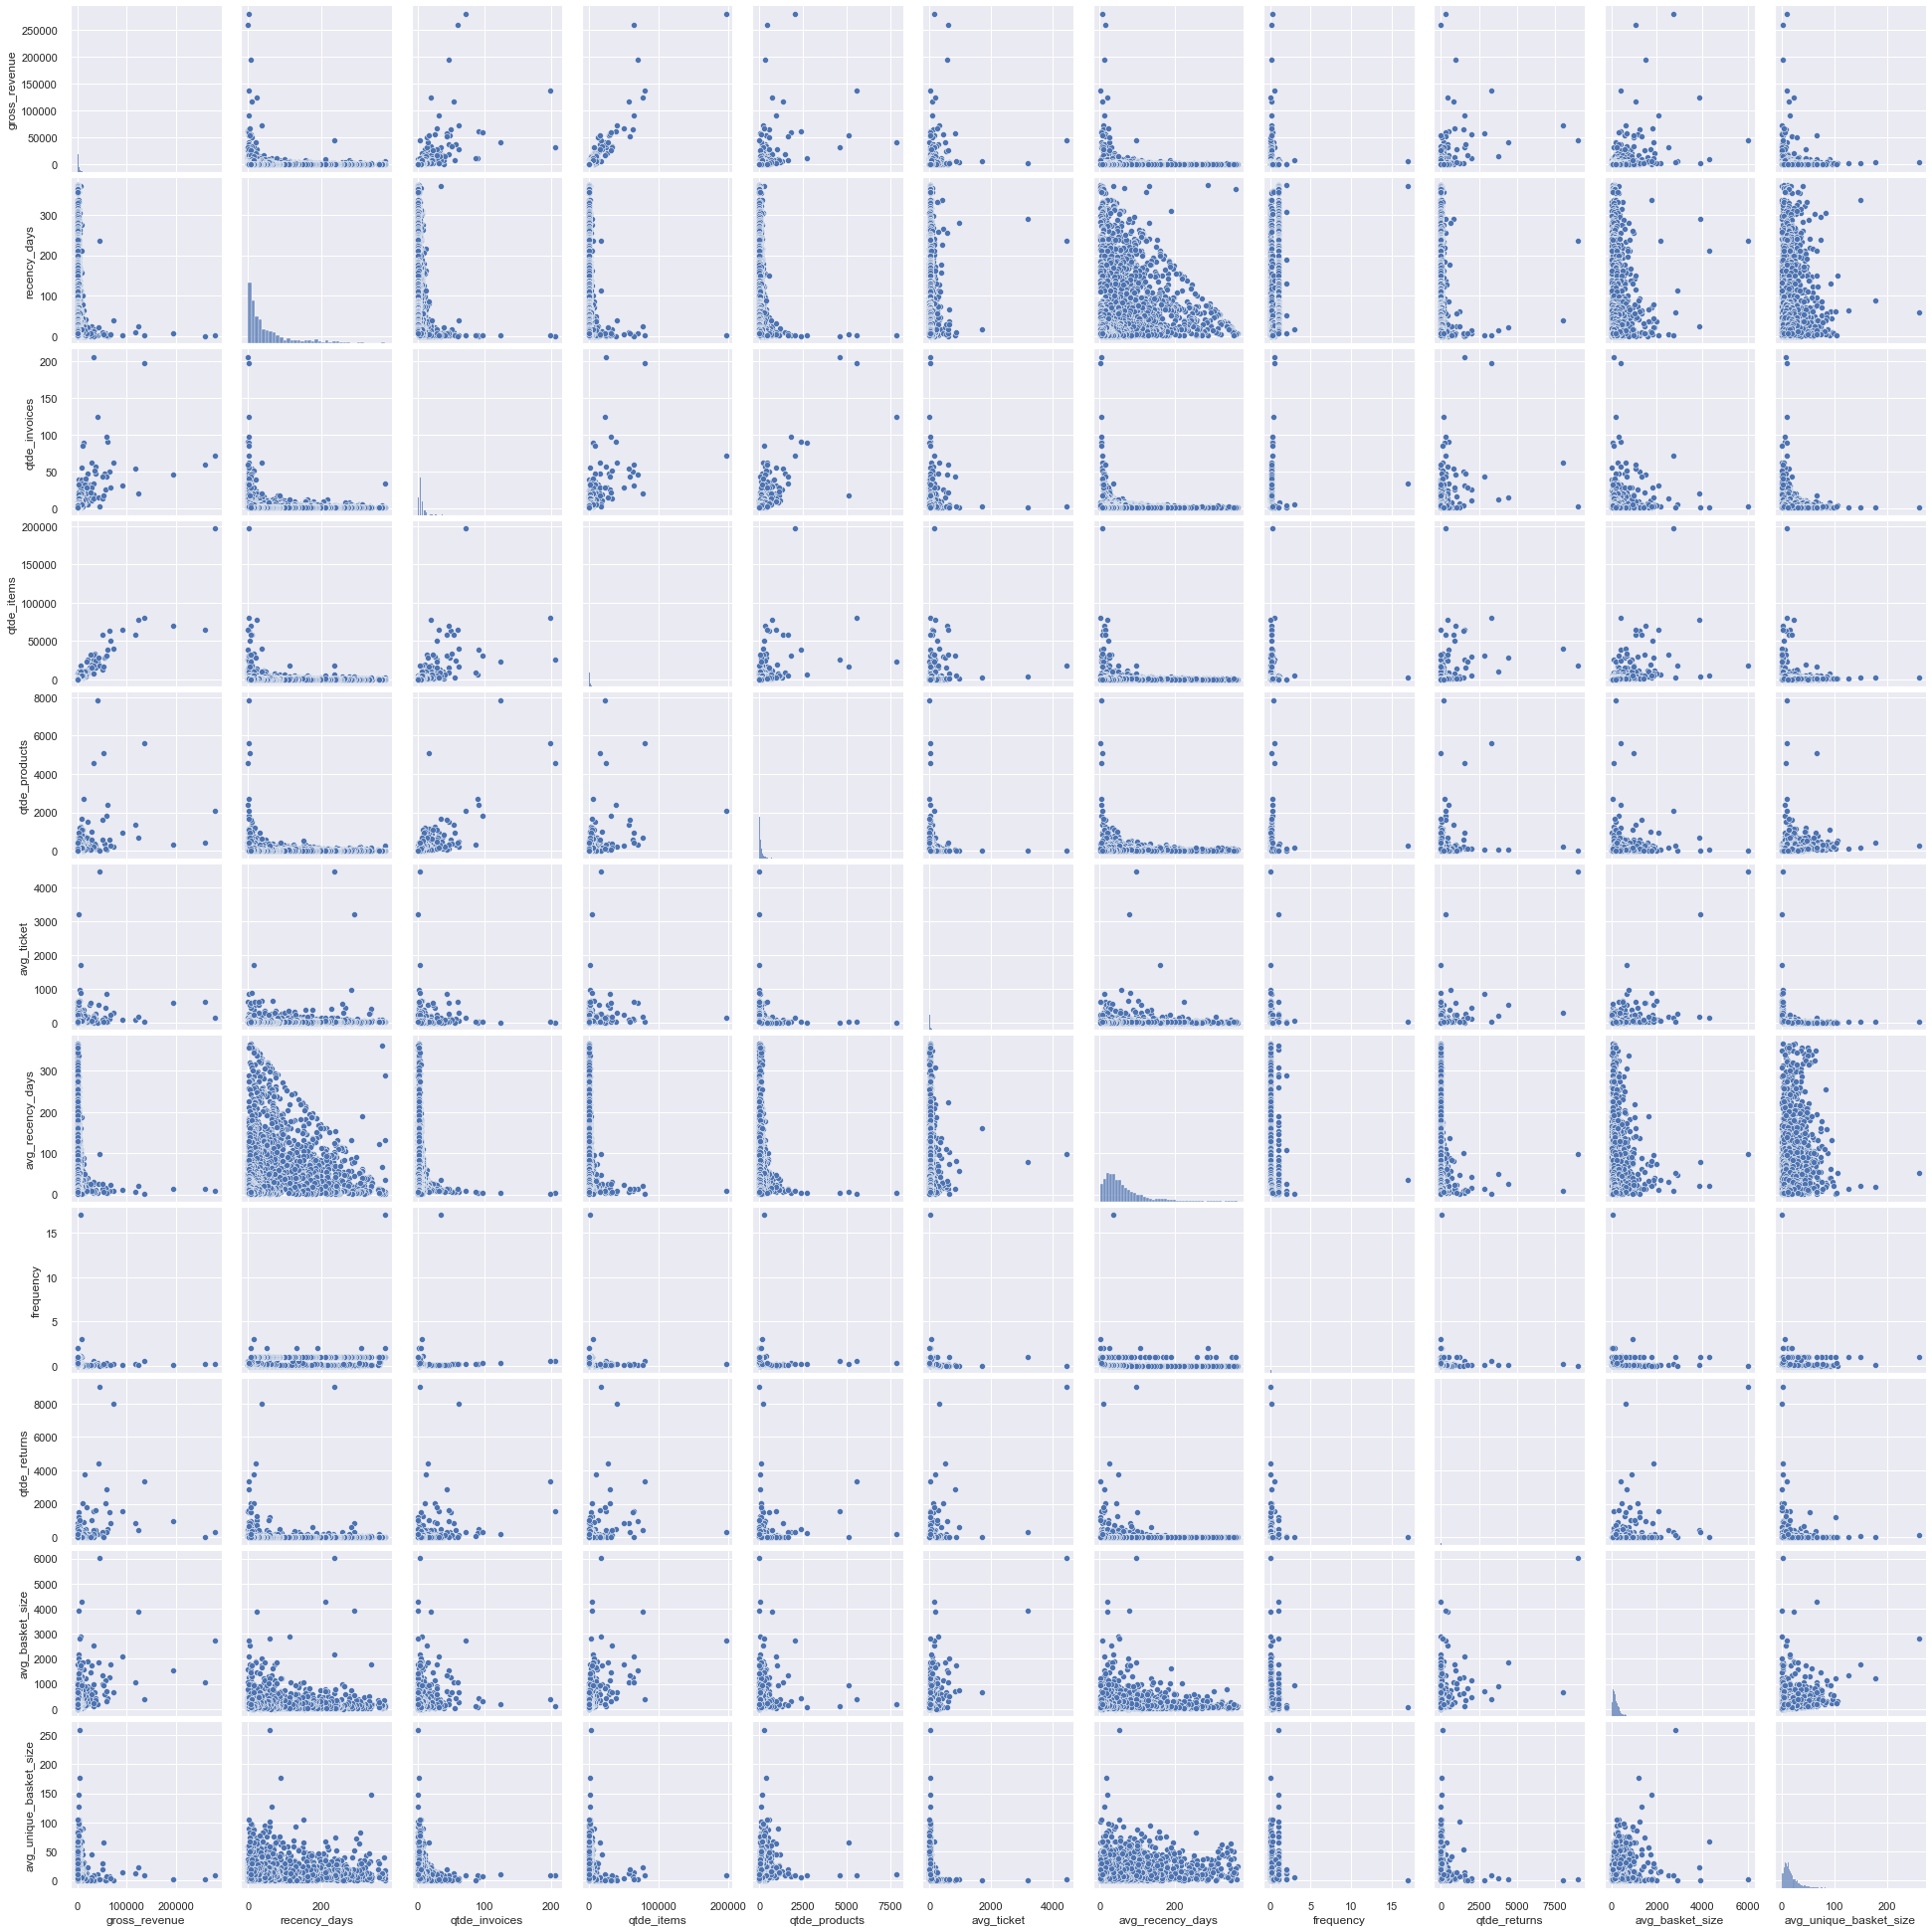

In [58]:
sns.pairplot(df42)

**Notes**

1. Frequency has low variance
2. Avg Ticket has low variance

## 4.3 Estudo do espaço

In [59]:
df43 = df4.drop(columns=['customer_id'] , axis=1).copy()

In [60]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['qtde_invoices'] = mm.fit_transform(df43[['qtde_invoices']])
df43['qtde_items'] = mm.fit_transform(df43[['qtde_items']])
df43['qtde_products'] = mm.fit_transform(df43[['qtde_products']])
df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qtde_returns'] = mm.fit_transform(df43[['qtde_returns']])
df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])


X = df43.copy()


In [61]:
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.02,1.00,0.16,0.01,0.04,0.00,0.09,1.00,0.00,0.01,0.00
1,0.01,0.15,0.04,0.01,0.02,0.00,0.07,0.00,0.00,0.03,0.04
2,0.02,0.01,0.07,0.03,0.03,0.01,0.06,0.00,0.01,0.06,0.03
3,0.00,0.25,0.02,0.00,0.00,0.01,0.25,0.00,0.00,0.01,0.02
4,0.00,0.89,0.01,0.00,0.00,0.07,0.02,0.00,0.00,0.00,0.00


### 4.3.1 PCA

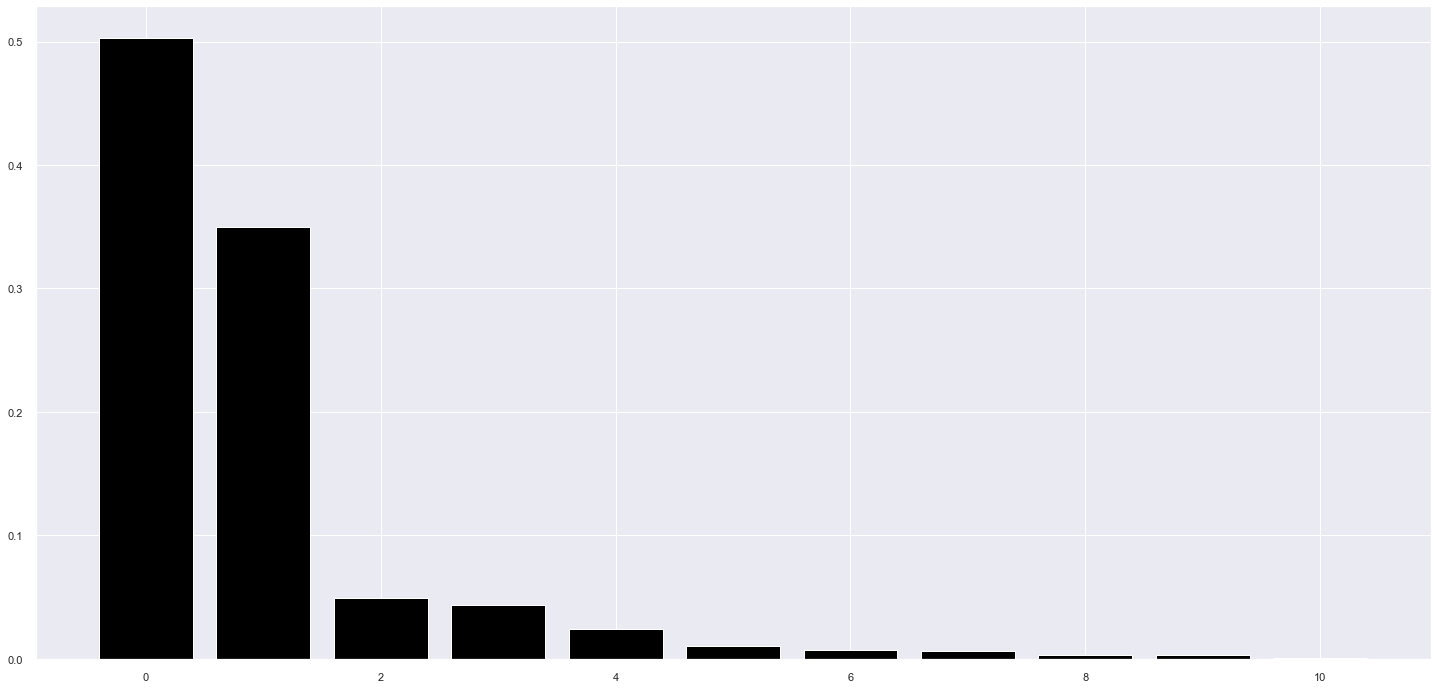

In [62]:
pca = dd.PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features , pca.explained_variance_ratio_ , color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

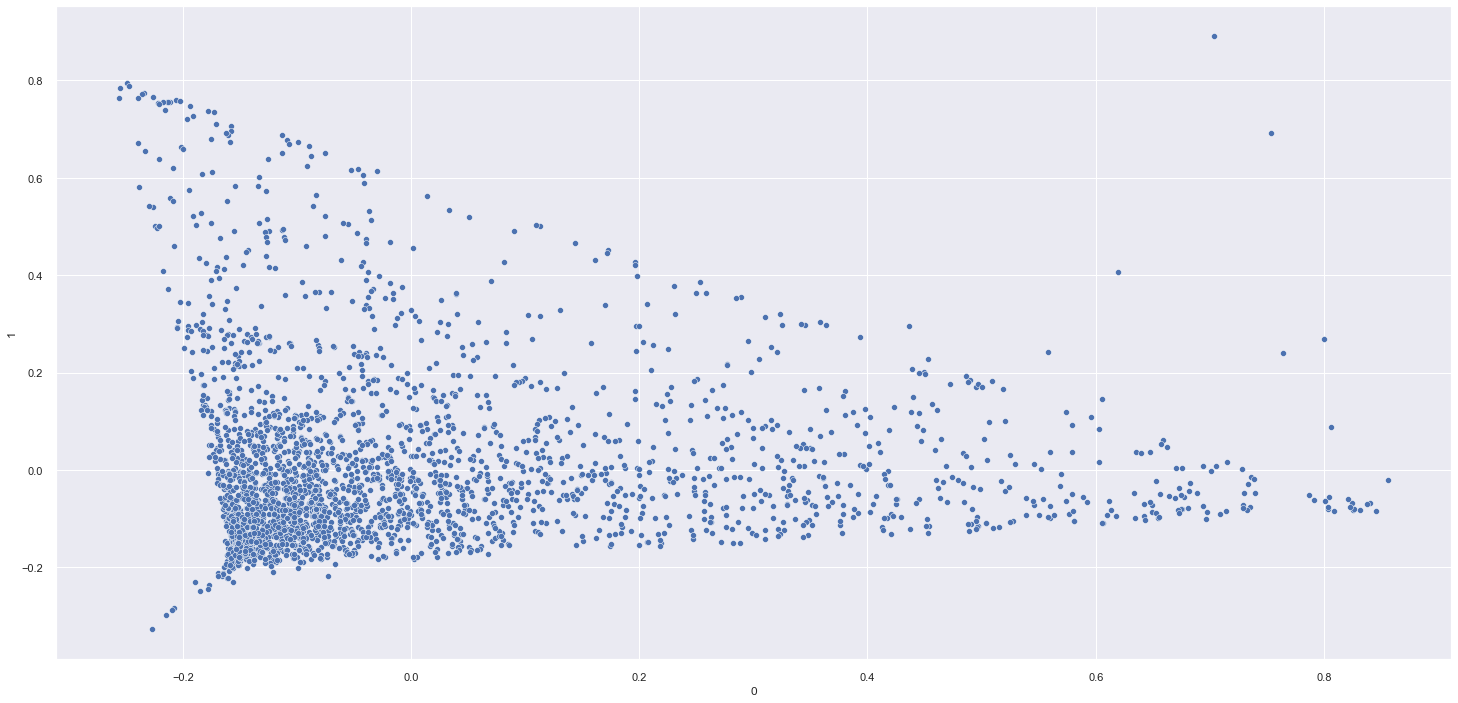

In [63]:
sns.scatterplot(x = 0 , y = 1, data=df_pca)

In [64]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.86,-0.02,0.05,0.13,-0.12,-0.06,-0.09,0.96,0.02,0.01,-0.00
1,-0.01,-0.11,-0.02,0.02,-0.01,-0.00,0.00,-0.01,-0.00,-0.00,0.00
2,-0.15,-0.15,0.00,0.04,0.00,0.00,-0.01,-0.00,-0.01,-0.01,-0.00
3,0.07,0.08,-0.04,0.04,0.00,0.00,0.00,-0.01,-0.00,-0.00,0.00
4,0.74,-0.08,-0.03,0.06,0.01,-0.02,0.00,-0.03,0.04,-0.01,-0.01


### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

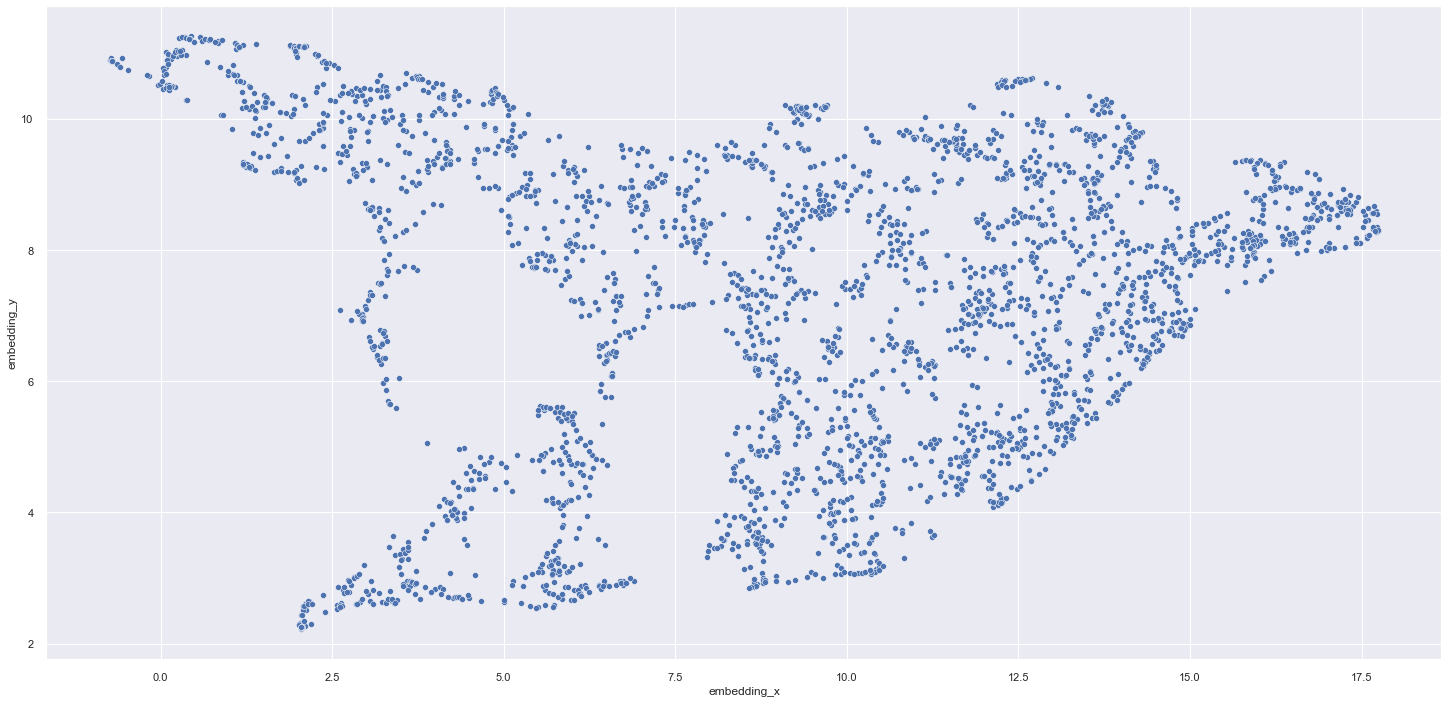

In [65]:
# reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)


# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


# plot UMAP
sns.scatterplot(x = 'embedding_x' ,
                y='embedding_y',
                data=df_pca)

### 4.3.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

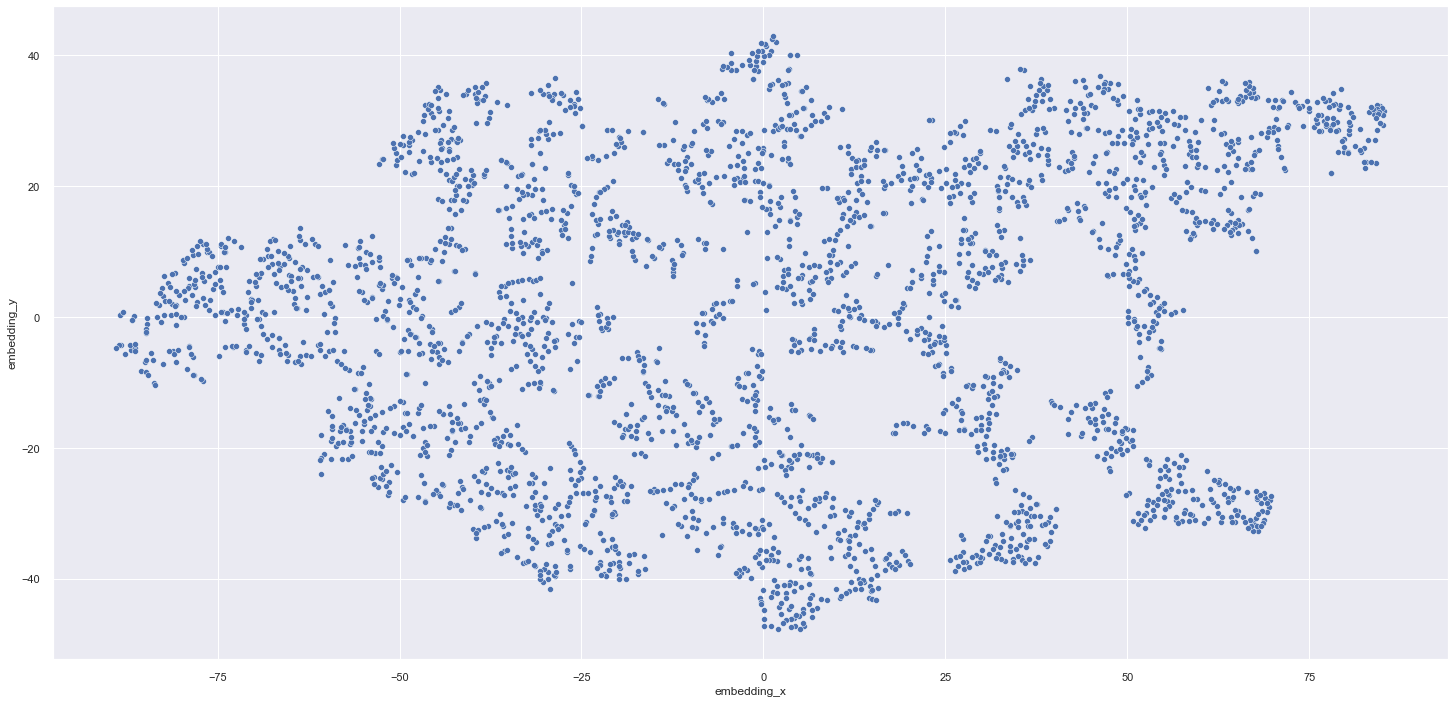

In [66]:
reducer = TSNE(n_components = 2, n_jobs = -1 , random_state=42)

embedding = reducer.fit_transform(X)


# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


# plot UMAP
sns.scatterplot(x = 'embedding_x' ,
                y='embedding_y',
                data=df_pca)

### 4.3.4 Tree-Based Embedding

não precisar fazer o minmaxscaler() para trabalhar com uma arvore

In [67]:
from sklearn import ensemble as en

In [68]:
# training dataset 

X = df4.drop(columns=['customer_id' , 'gross_revenue'], axis =1)
Y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 100 , random_state=42 )

# model training
rf_model.fit(X,Y)

# Leaf

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [69]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [70]:
df_leaf.shape

(2965, 100)

In [71]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3412,3326,2986,3374,3047,3156,3108,3039,3267,3100,...,3312,3086,3063,3115,3246,3172,3291,3120,3307,3308
1,3053,3021,2976,2960,2804,3140,2723,2826,2916,2996,...,2867,2992,2956,3103,2849,2767,2849,3112,2890,3002
2,3590,3539,3589,3608,3526,3610,3582,3433,3665,3578,...,3568,3504,3540,3475,3565,3628,3500,3642,3567,3641
3,1469,2065,1809,1496,1718,1571,1878,1266,1774,1512,...,1514,1548,1535,1584,1392,1886,2031,2180,1592,1463
4,173,547,140,409,556,540,559,204,610,185,...,174,491,573,611,673,618,485,597,562,190


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

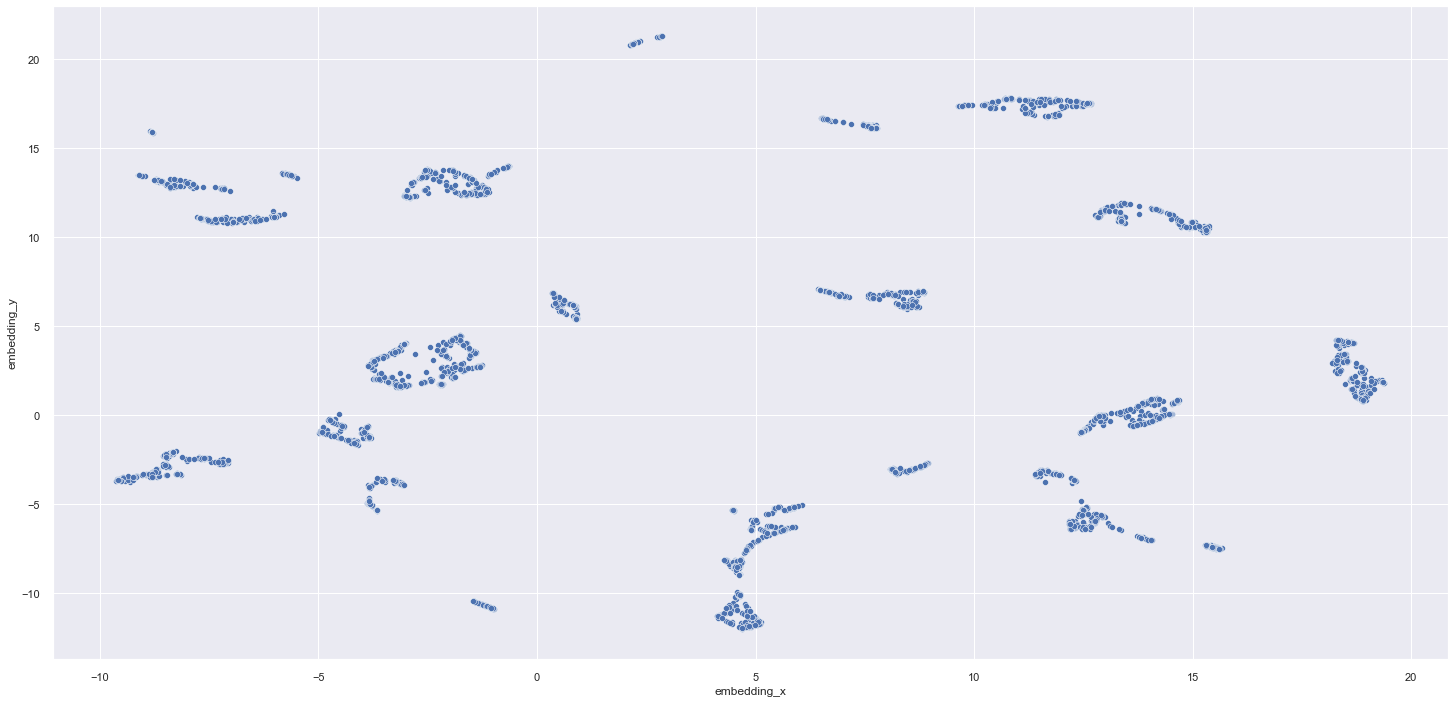

In [72]:
# reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)


# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


# plot UMAP
sns.scatterplot(x = 'embedding_x' ,
                y='embedding_y',
                data=df_pca)

# <font color ='red'> 5.0 Data Preparation </font>


In [73]:
df5 = df4.copy()

In [74]:
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform(df43[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df43[['recency_days']])
df5['qtde_invoices'] = ss.fit_transform(df43[['qtde_invoices']])
df5['qtde_items'] = ss.fit_transform(df43[['qtde_items']])
df5['qtde_products'] = ss.fit_transform(df43[['qtde_products']])
df5['avg_ticket'] = ss.fit_transform(df43[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df43[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df43[['frequency']])
df5['qtde_returns'] = ss.fit_transform(df43[['qtde_returns']])
df5['avg_basket_size'] = ss.fit_transform(df43[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df43[['avg_unique_basket_size']])

In [79]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.02,1.00,0.16,0.01,0.04,0.00,0.09,1.00,0.00,0.01,0.00
1,13047,0.01,0.15,0.04,0.01,0.02,0.00,0.07,0.00,0.00,0.03,0.04
2,12583,0.02,0.01,0.07,0.03,0.03,0.01,0.06,0.00,0.01,0.06,0.03
3,13748,0.00,0.25,0.02,0.00,0.00,0.01,0.25,0.00,0.00,0.01,0.02
4,15100,0.00,0.89,0.01,0.00,0.00,0.07,0.02,0.00,0.00,0.00,0.00


<AxesSubplot:xlabel='gross_revenue', ylabel='Density'>

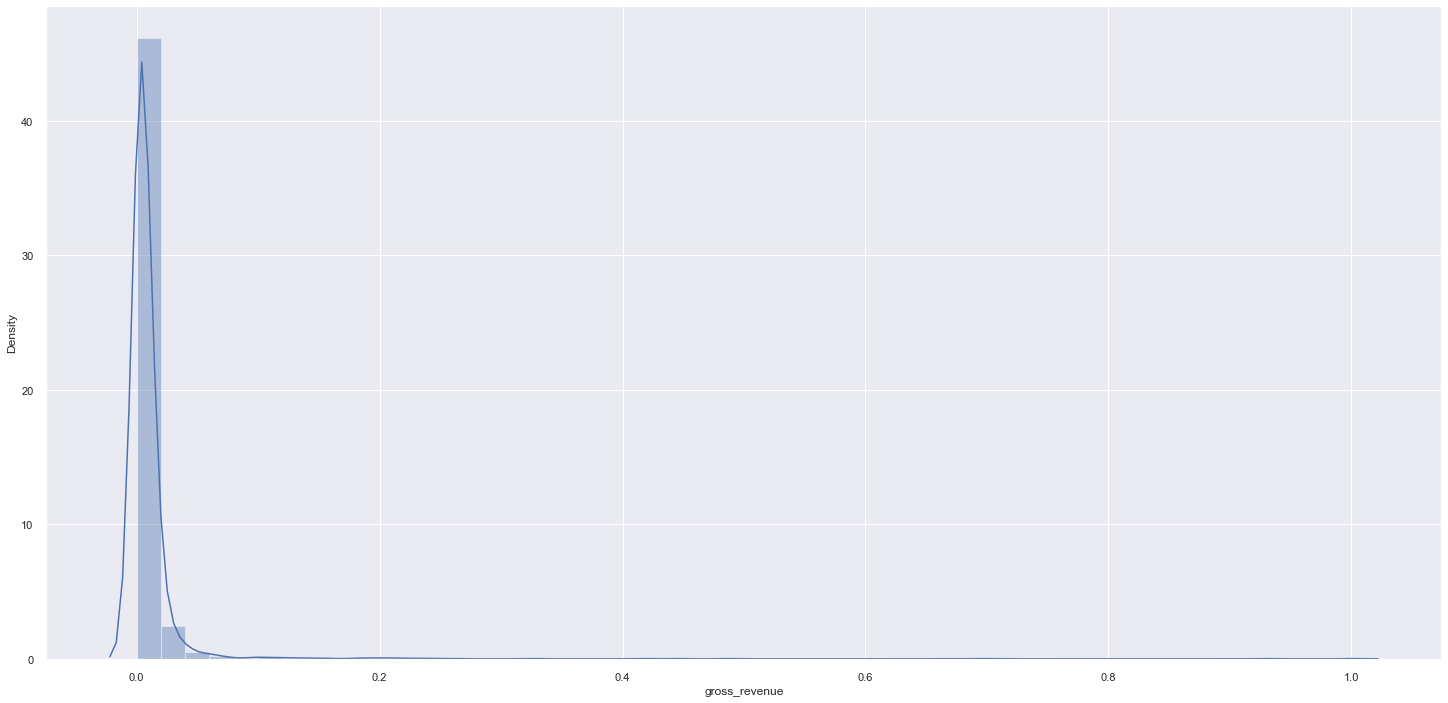

In [85]:
sns.distplot((df5['gross_revenue']))

# <font color ='red'> 6.0 Feature Selection </font>

In [86]:
df6 = df5.copy()

# <font color ='red'> 7.0 Hyperparameter Fine-Tunning </font>

In [87]:
x = df6.drop(columns=['customer_id'] , axis=1)

In [88]:
x.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.02,1.00,0.16,0.01,0.04,0.00,0.09,1.00,0.00,0.01,0.00
1,0.01,0.15,0.04,0.01,0.02,0.00,0.07,0.00,0.00,0.03,0.04
2,0.02,0.01,0.07,0.03,0.03,0.01,0.06,0.00,0.01,0.06,0.03
3,0.00,0.25,0.02,0.00,0.00,0.01,0.25,0.00,0.00,0.01,0.02
4,0.00,0.89,0.01,0.00,0.00,0.07,0.02,0.00,0.00,0.00,0.00


In [89]:
clusters = [2,3,4,5,6,7]

##

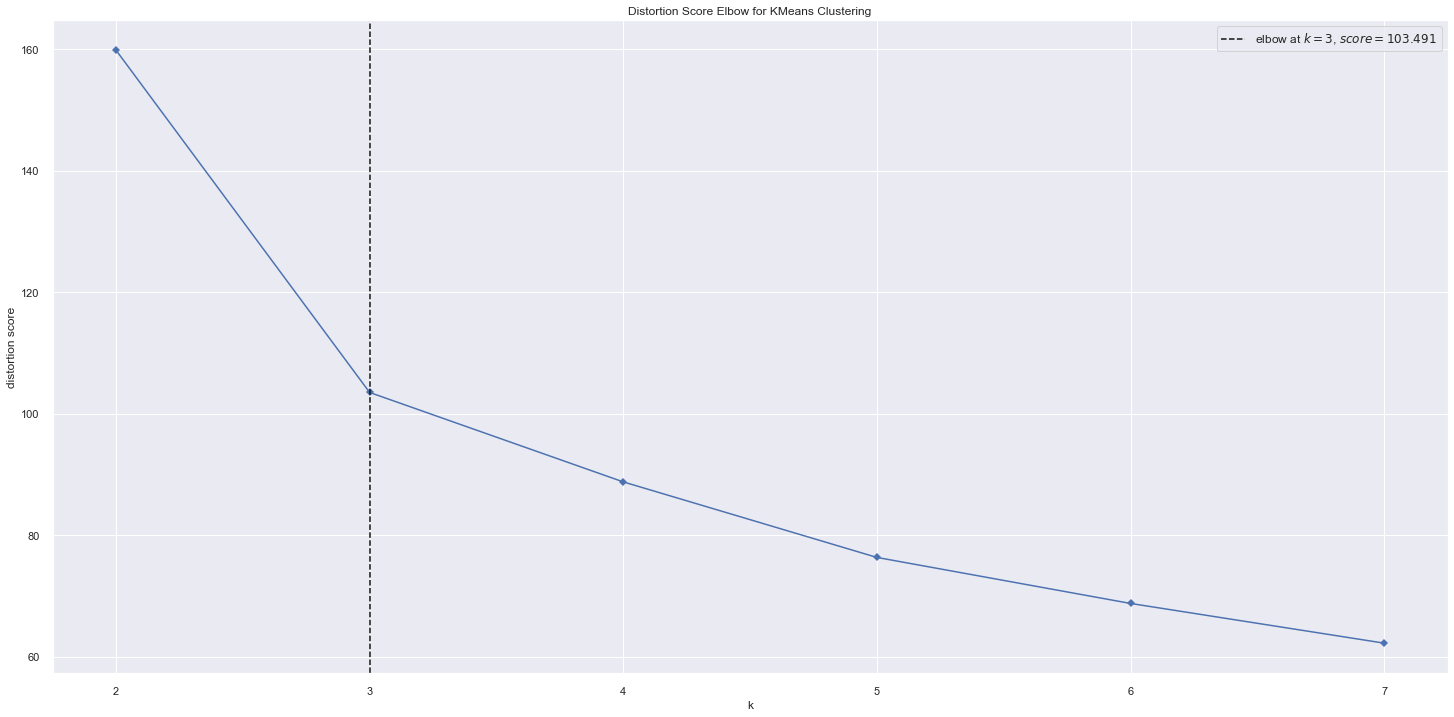

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
kmeans = KElbowVisualizer(c.KMeans() , k=clusters , timings= False)
kmeans.fit(x)
kmeans.show()

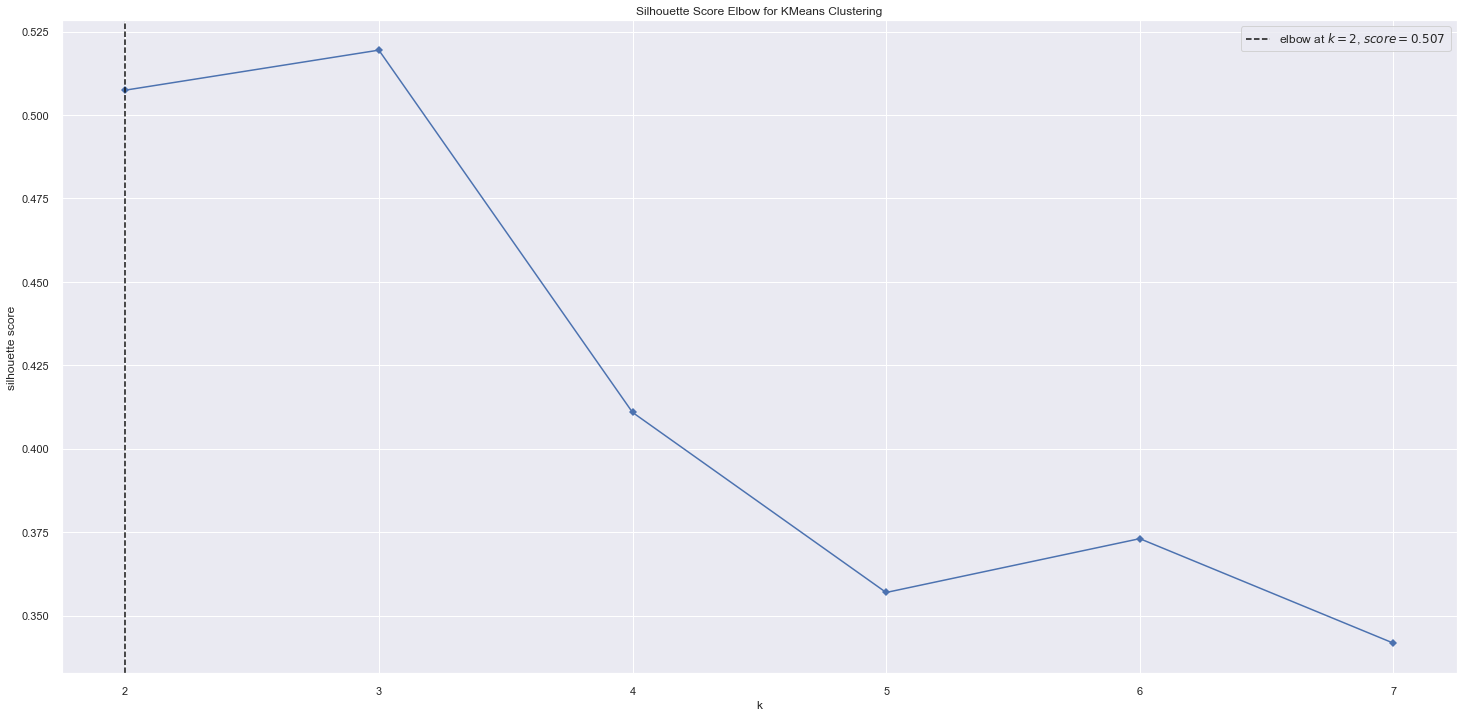

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [91]:
kmeans = KElbowVisualizer(c.KMeans() , k=clusters ,metric='silhouette', timings= False)
kmeans.fit(x)
kmeans.show()

## 7.1 Silhouette Analysis

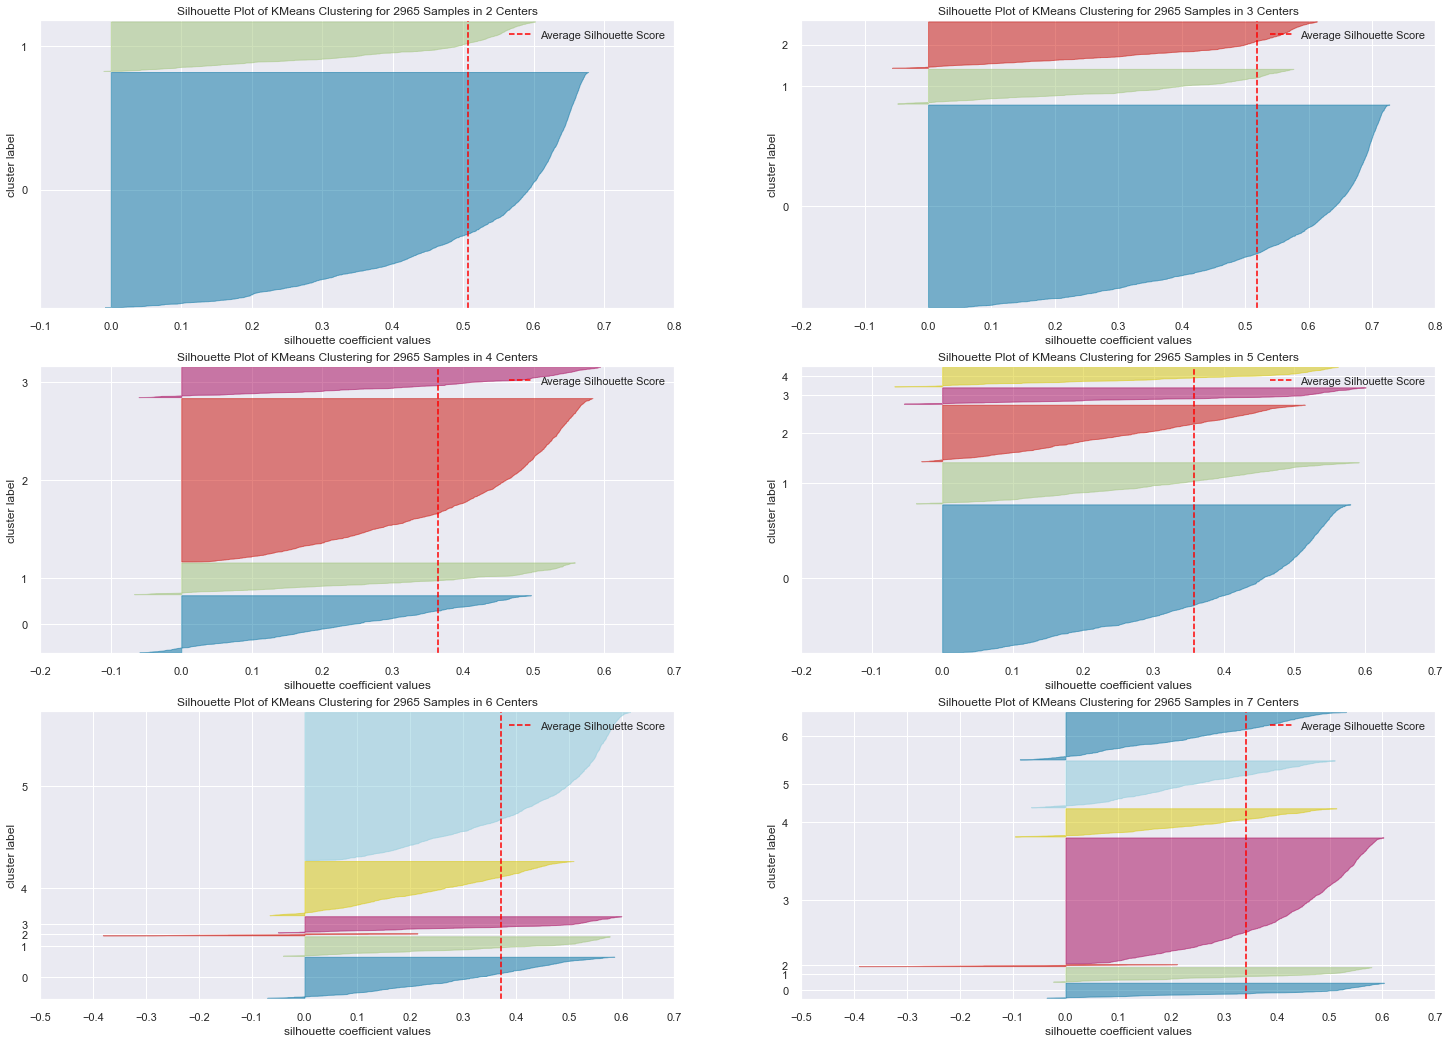

In [92]:
fig , ax = plt.subplots(3,2 , figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k , init='random', n_init=10 , max_iter=100 , random_state=42)
    q, mod = divmod(k , 2)
    visualizer = SilhouetteVisualizer(km , colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x)
    visualizer.finalize()

# <font color ='red'> 8.0 Model Training </font>

In [93]:
df8 = x.copy()

In [94]:
df8.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.02,1.00,0.16,0.01,0.04,0.00,0.09,1.00,0.00,0.01,0.00
1,0.01,0.15,0.04,0.01,0.02,0.00,0.07,0.00,0.00,0.03,0.04
2,0.02,0.01,0.07,0.03,0.03,0.01,0.06,0.00,0.01,0.06,0.03
3,0.00,0.25,0.02,0.00,0.00,0.01,0.25,0.00,0.00,0.01,0.02
4,0.00,0.89,0.01,0.00,0.00,0.07,0.02,0.00,0.00,0.00,0.00


## 8.1 K-Means

In [95]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_


## 8.2 Cluster Validation

In [96]:
from sklearn                       import metrics as m

In [97]:
## Wss (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhoute Score)
print('SS value: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS value: 103.49081495165997
SS value: 0.5194457466868324


# <font color ='red'> 9.0 Cluster Analysis </font>

In [98]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.02,1.00,0.16,0.01,0.04,0.00,0.09,1.00,0.00,0.01,0.00,2
1,13047,0.01,0.15,0.04,0.01,0.02,0.00,0.07,0.00,0.00,0.03,0.04,0
2,12583,0.02,0.01,0.07,0.03,0.03,0.01,0.06,0.00,0.01,0.06,0.03,0
3,13748,0.00,0.25,0.02,0.00,0.00,0.01,0.25,0.00,0.00,0.01,0.02,0
4,15100,0.00,0.89,0.01,0.00,0.00,0.07,0.02,0.00,0.00,0.00,0.00,2


## 9.1 Vizualization Inspection

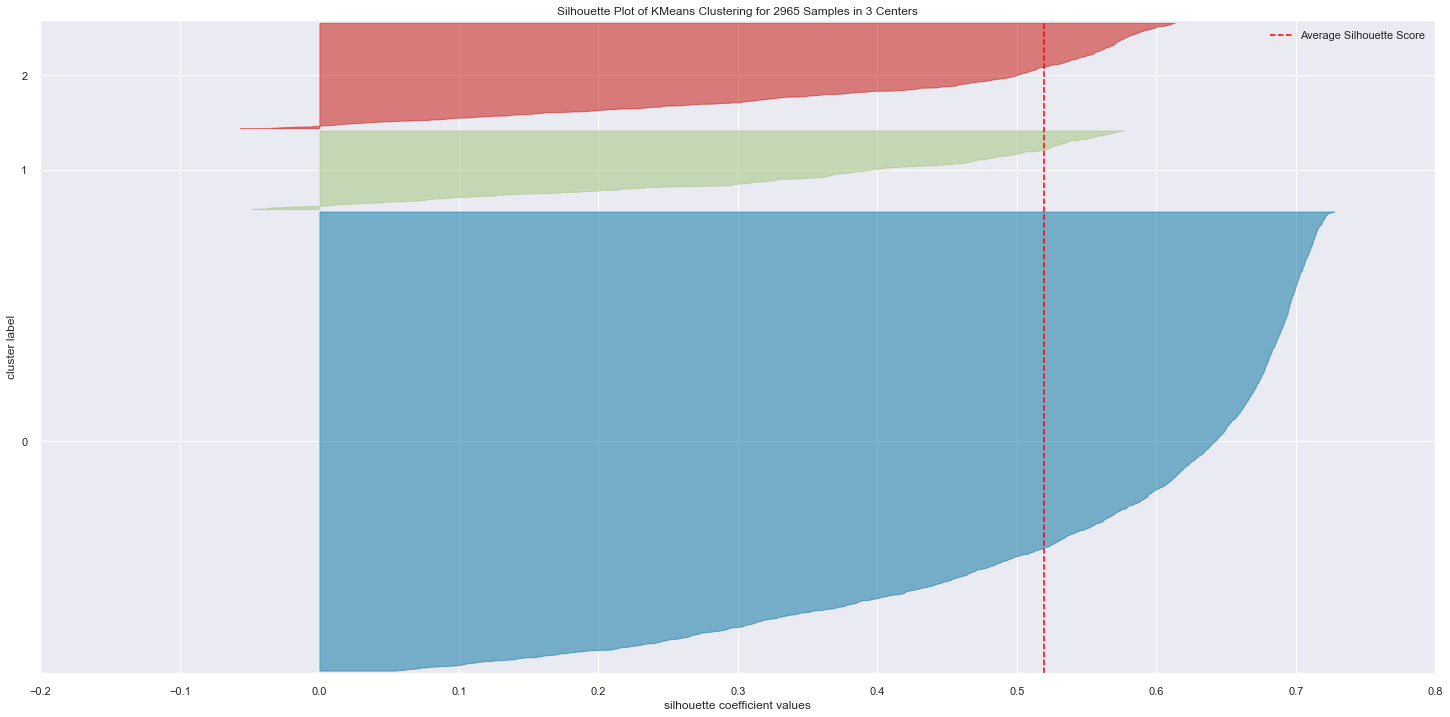

In [99]:
visualizer = SilhouetteVisualizer(kmeans ,  colors='yellowbrick')
visualizer.fit(x)
visualizer.finalize()


## 9.2 2D Plot


In [100]:
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.02,1.00,0.16,0.01,0.04,0.00,0.09,1.00,0.00,0.01,0.00,2
1,13047,0.01,0.15,0.04,0.01,0.02,0.00,0.07,0.00,0.00,0.03,0.04,0
2,12583,0.02,0.01,0.07,0.03,0.03,0.01,0.06,0.00,0.01,0.06,0.03,0
3,13748,0.00,0.25,0.02,0.00,0.00,0.01,0.25,0.00,0.00,0.01,0.02,0
4,15100,0.00,0.89,0.01,0.00,0.00,0.07,0.02,0.00,0.00,0.00,0.00,2


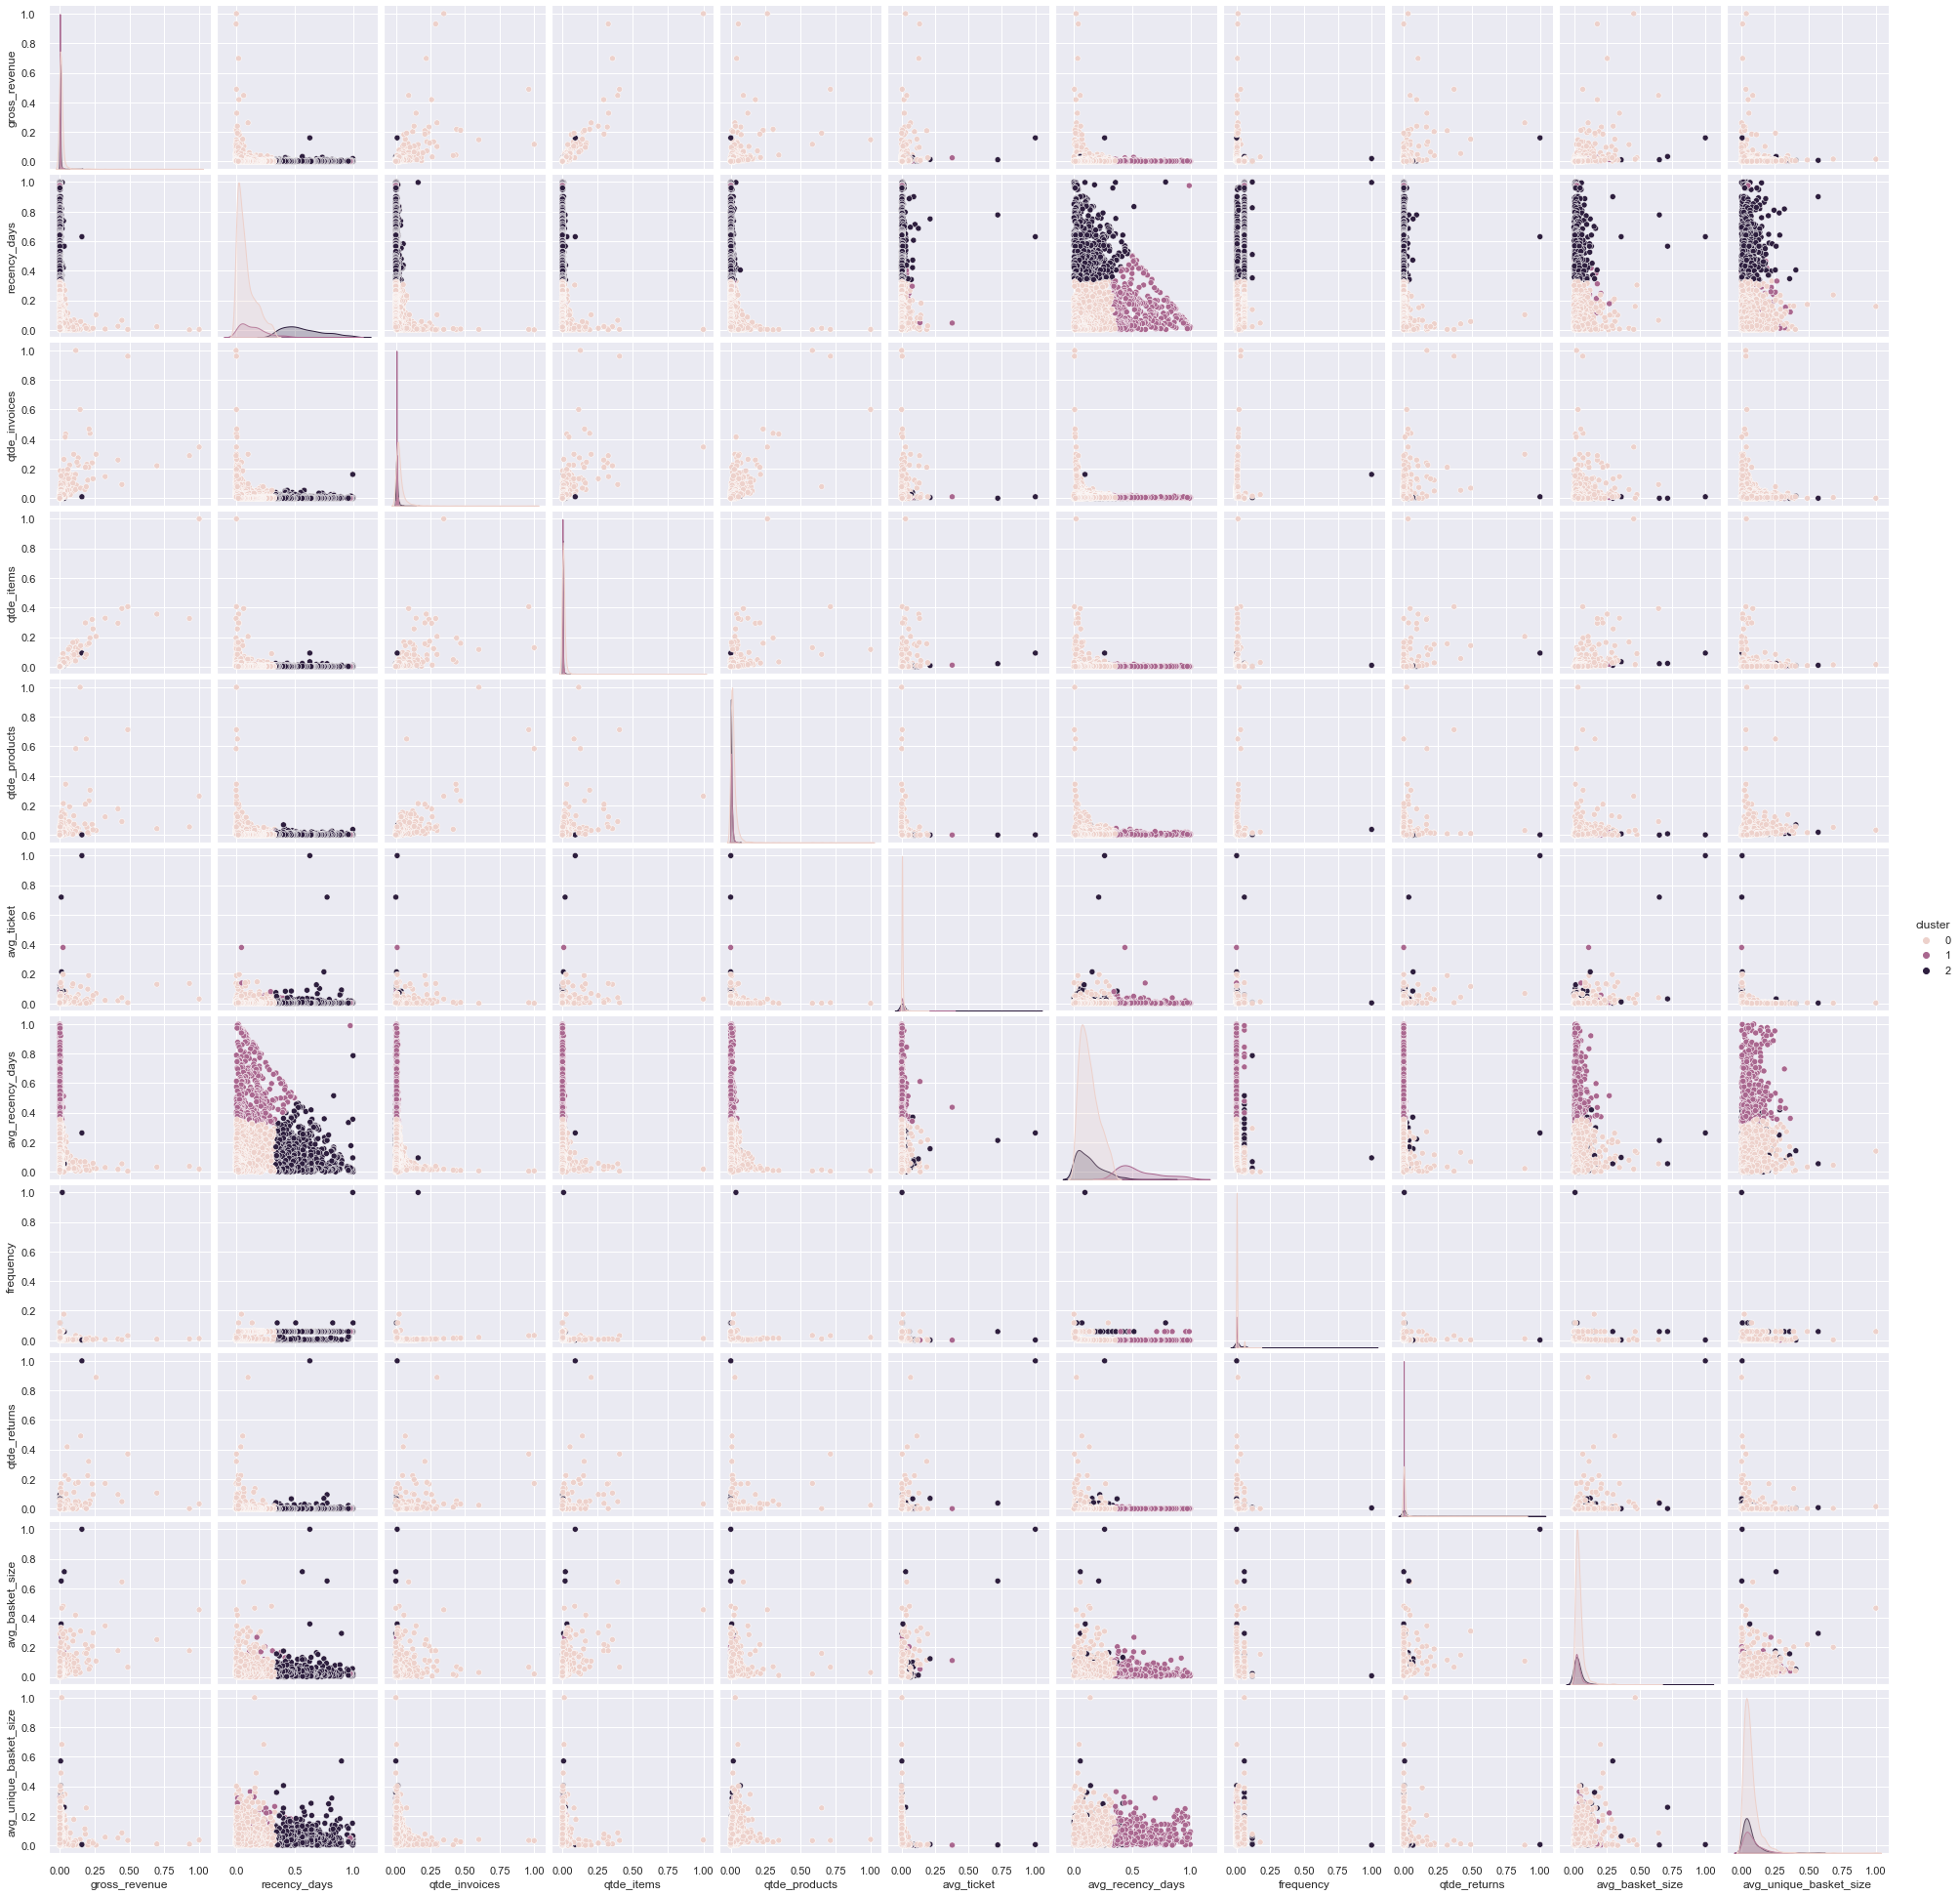

In [101]:
df_viz = df9.drop(columns='customer_id', axis =1)
sns.pairplot(df_viz , hue='cluster')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

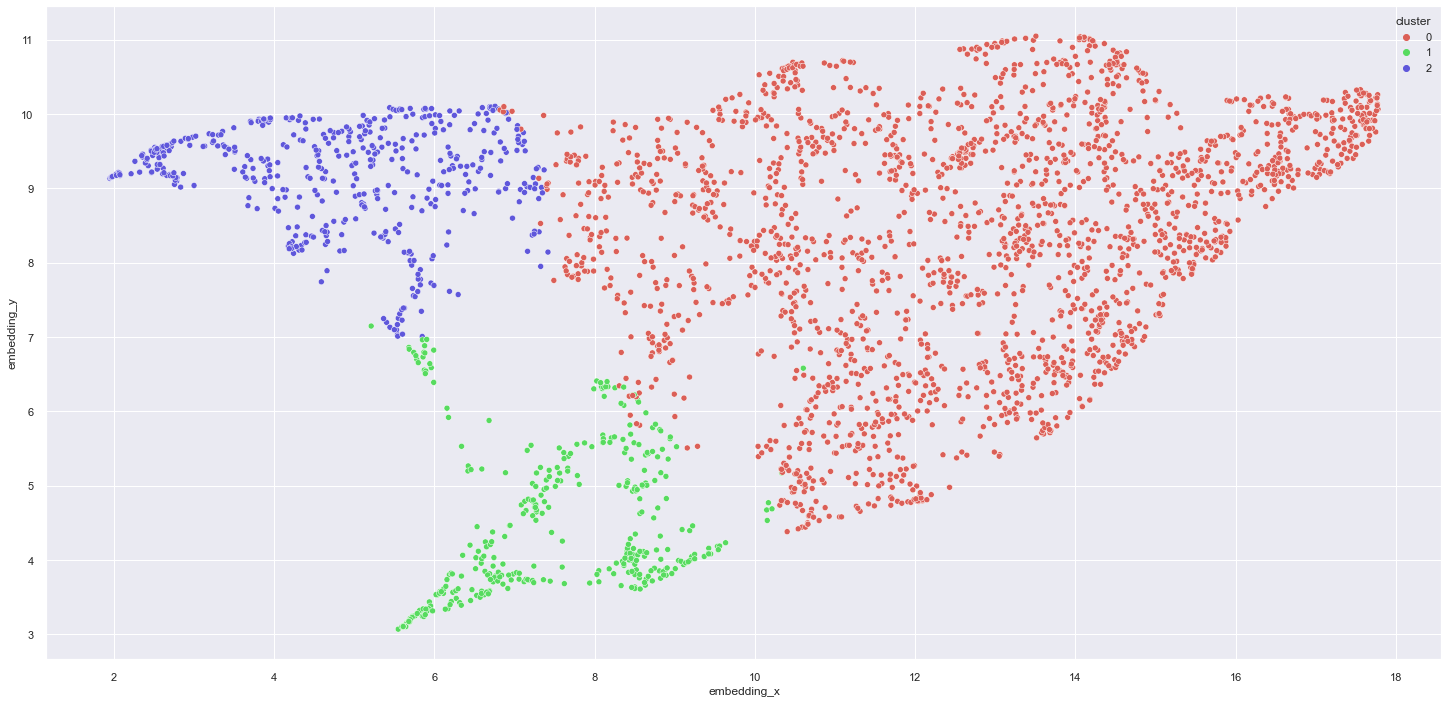

In [102]:
reducer = umap.UMAP(n_neighbors=40,random_state=42)
embedding = reducer.fit_transform(x)


# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]


# plot UMAP
sns.scatterplot(x = 'embedding_x' , y='embedding_y',
                hue='cluster' ,
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

In [103]:
# fig = px.scatter_3d(df9, x='recency_days',y='invoice_no',z='gross_revenue', color='cluster')
# fig.show()

## 9.2 Cluster Profile


In [104]:
# Number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customers'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster , df_avg_gross_revenue , how='inner' , on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster , df_avg_recency_days , how='inner' , on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['qtde_invoices','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster , df_avg_invoice_no , how='inner' , on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster , df_ticket , how='inner' , on='cluster')
 

df_cluster

,cluster,customer_id,perc_customers,gross_revenue,recency_days,qtde_invoices,avg_ticket
0,0,2116,71.37,0.01,0.08,0.03,0.01
1,1,363,12.24,0.00,0.14,0.01,0.01
2,2,486,16.39,0.00,0.57,0.01,0.01


### Cluster 01: ( Candidato a Insiders)

    - Número de customers: 6 (0.14% do customers)
    - Recência em média: 7 dias 
    - Compras em média: 89 compras
    - Receita em média: $ 182.182,00 dólares
    
### Cluster 02: 

    - Número de customers: 31 (0.71% do customers)
    - Recência em média: 14 dias 
    - Compras em média: 53 compras
    - Receita em média: $ 40.543,52 dólares

### Cluster 03: 

    - Número de customers: 4.335 (99.15% do customers)
    - Recência em média: 92 dias 
    - Compras em média: 5 compras
    - Receita em média: $ 1.372,57 dólares

# <font color ='red'> 10.0 Deploy to production </font>

In [105]:
df10 = df9.copy()